In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
from sqlalchemy import create_engine
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from matplotlib.lines import Line2D
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Connect to a SQL database
engine = create_engine('sqlite:///barnet_crimes.db', echo=False)

# Execute a SQL query and load data into a pandas dataframe
query = "SELECT * FROM barnet "
df = pd.read_sql_query(query, engine)

# Close the database connection
engine.dispose()

In [3]:

# Extract the common prefix using regex pattern
df['MSOA'] = df['LSOA name'].apply(lambda x: re.match(r'(^\w+ \d+)', x).group())
# Convert the Month to datetime attribute
#df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')
# Extract data for burglary and theft
df_burg = df[df['Crime type']=='Burglary']
df_theft = df[df['Crime type']=='Other theft']
# We focus on Hendon and West Hendon wards
areas = ['Barnet']
lsoa_codes = ['031A', '031B', '031C', '032A', '032B', '032C', '032D', '032E', '034A', '034B', '034D', '031D', '032F', '034C', '039D', '036B', '036C', '036D', '036F']
combined_list = [area + ' ' + code for area in areas for code in lsoa_codes]
# Extract the data for burglary and theft
hendon_burg = df_burg[df_burg['LSOA name'].isin(combined_list)]
hendon_theft = df_theft[df_theft['LSOA name'].isin(combined_list)]


In [4]:
hendon_theft_count = hendon_theft.groupby('Month')[['Crime type']].count()
hendon_theft_count = hendon_theft_count.rename(columns={'Crime type':'theft counts'})

In [5]:
hendon_theft_count

,theft counts
Month,
2011-09,40
2011-10,45
2011-11,52
2011-12,34
2012-01,48
...,...
2022-09,30
2022-10,41
2022-11,36


In [6]:

#hendon_burg['dt_year'] = hendon_burg['Month'].dt.year
#hendon_burg['dt_month'] = hendon_burg['Month'].dt.month
#hendon_year = hendon_burg.groupby('dt_year')[['Crime type']].count()
#hendon_year = hendon_year.rename(columns={'Crime type':'burglary counts'})
#hendon_month = hendon_burg[hendon_burg['Month']>='2019-03'].groupby('dt_month')[['Crime type']].count()
#hendon_month = hendon_month.rename(columns={'Crime type':'burglary counts'})
#hendon_time = hendon_burg.groupby('Month')[['Crime type']].count()
#hendon_time = hendon_time.rename(columns={'Crime type':'burlary counts'})
#hendon_month.plot(kind='line',figsize=(5, 3))

## Stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
burg_count = df[df['Crime type']=='Burglary'].groupby('Month')[['Crime type']].count()
burg_count = burg_count.rename(columns={'Crime type':'burglary counts'})
hendon_burg_count = hendon_burg.groupby('Month')[['Crime type']].count()
hendon_burg_count = hendon_burg_count.rename(columns={'Crime type':'burglary counts'})

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=3).mean()
    rolstd = timeseries.rolling(window=3).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:') 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


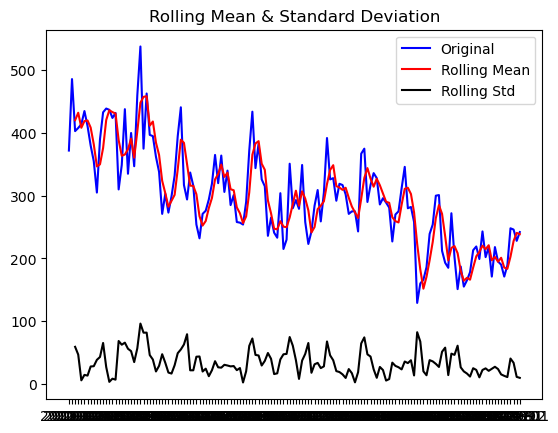

Results of Dickey-Fuller Test:
Test Statistic                  -1.093221
p-value                          0.717768
#Lags Used                      11.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


In [9]:
test_stationarity(burg_count)

- This suggests that the time series may not be stationary and likely possesses some degree of trend or seasonality. 

In [10]:
hendon_burg_count

,burglary counts
Month,
2010-12,48
2011-01,46
2011-02,44
2011-03,51
2011-04,47
...,...
2022-09,15
2022-10,32
2022-11,27


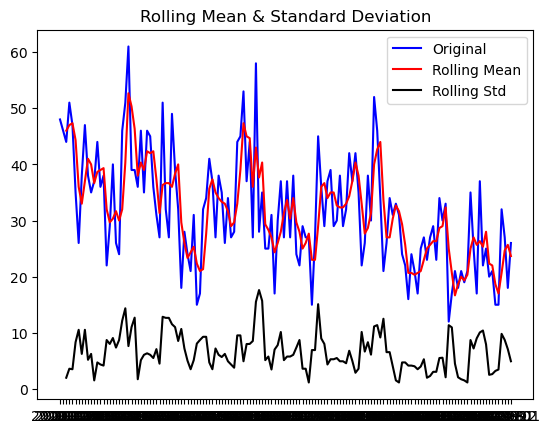

Results of Dickey-Fuller Test:
Test Statistic                  -5.349315
p-value                          0.000004
#Lags Used                       1.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [11]:
test_stationarity(hendon_burg_count)

- This provides strong evidence against the null hypothesis of non-stationarity, suggesting that the time series is likely stationary.

## Forecasting Hendon & West Hendon burglary

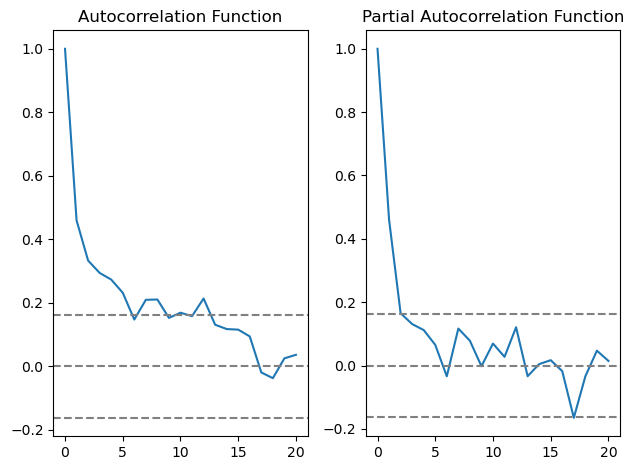

In [12]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(hendon_burg_count, nlags=20)
lag_pacf = pacf(hendon_burg_count, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(hendon_burg_count)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(hendon_burg_count)), linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(hendon_burg_count)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(hendon_burg_count)), linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()



The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:

• p: The first time where the PACF crosses the upper confidence interval, here its close to 3. hence p = 3.

• q: The first time where the ACF crosses the upper confidence interval, here its close to 6. hence q = 6.

#### AR model

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


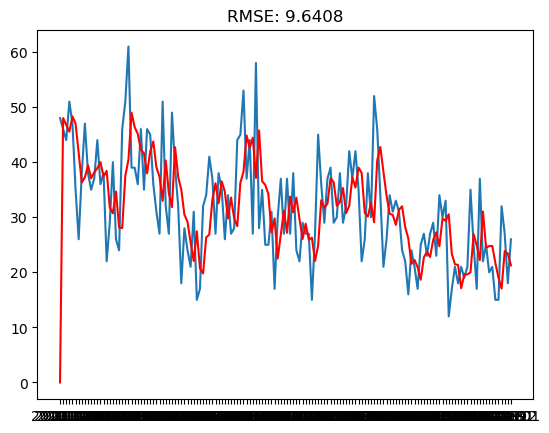

In [13]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(hendon_burg_count, order=(3, 1, 0))

# Fit the ARIMA model to the data
results_AR = model.fit()
# Get the residuals from the fitted ARIMA model
residuals = results_AR.resid

# Calculate the mean squared error (MSE)
mse = np.mean(residuals ** 2)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Plotting the original data and the fitted values
plt.plot(hendon_burg_count)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse)
plt.show()


#### MA model

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


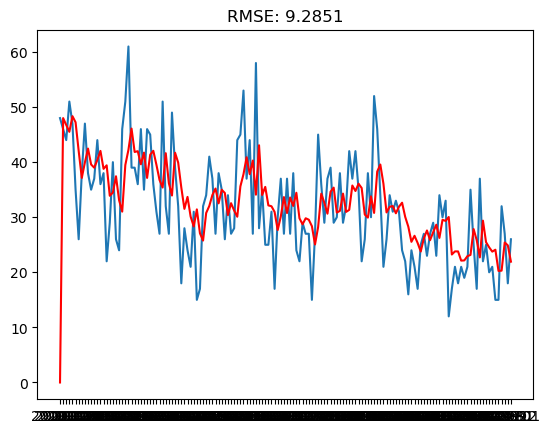

In [14]:
model = sm.tsa.ARIMA(hendon_burg_count, order=(0, 1, 6))

# Fit the ARIMA model to the data
results_MA = model.fit()

# Plotting the original data and the fitted values
plt.plot(hendon_burg_count)
plt.plot(results_MA.fittedvalues, color='red')
# Get the residuals from the fitted ARIMA model
residuals = results_MA.resid

# Calculate the mean squared error (MSE)
mse = np.mean(residuals ** 2)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
plt.title('RMSE: %.4f' % rmse)
plt.show()

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimizati

Mean Absolute Error (MAE): 6.496959695444313


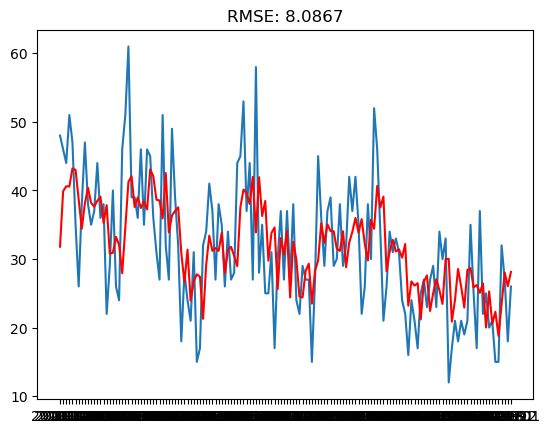

In [42]:
model = sm.tsa.ARIMA(hendon_burg_count, order=(8, 0, 9))

# Fit the ARIMA model to the data
results_ARIMA = model.fit()
# Get the residuals from the fitted ARIMA model
residuals = results_ARIMA.resid

# Calculate the mean squared error (MSE)
mse = np.mean(residuals ** 2)
mae = np.mean(np.abs(residuals))
print("Mean Absolute Error (MAE):", mae)
# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
# Plotting the original data and the fitted values
plt.plot(hendon_burg_count)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse)
plt.show()

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provide

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parame

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parame

C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregre

Best ARIMA Model:
Order: (8, 0, 9)
RSS: 9547.638423280478


C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


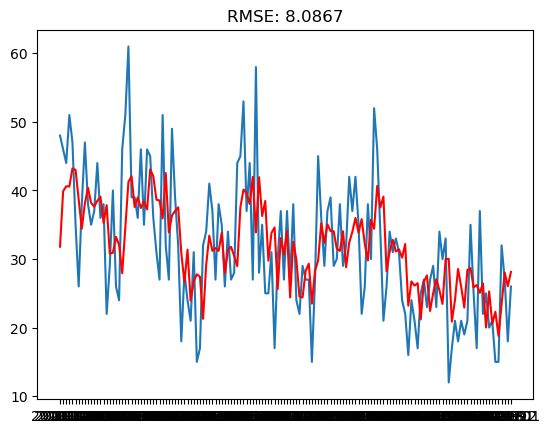

In [16]:
import statsmodels.api as sm
import numpy as np

def find_best_arima(data, p_values, d_values, q_values):
    best_aic = float("inf")
    best_params = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = sm.tsa.ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    rss = np.sum((results.fittedvalues - data)**2)
                    
                    if rss < best_aic:
                        best_aic = rss
                        best_params = (p, d, q)
                        
                except:
                    continue
    
    print("Best ARIMA Model:")
    print(f"Order: {best_params}")
    print(f"RSS: {best_aic}")
    
    return best_params

# Example usage
p_values = range(3, 10)
d_values = range(0, 2)
q_values = range(6, 10)

best_params = find_best_arima(hendon_burg_count['burglary counts'], p_values, d_values, q_values)

# Fit the ARIMA model with the best parameters
model = sm.tsa.ARIMA(hendon_burg_count['burglary counts'], order=best_params)
results_ARIMA = model.fit()
# Get the residuals from the fitted ARIMA model
residuals = results_ARIMA.resid

# Calculate the mean squared error (MSE)
mse = np.mean(residuals ** 2)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
# Plotting the original data and the fitted values
plt.plot(hendon_burg_count['burglary counts'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RMSE: %.4f' % rmse)
plt.show()


### XGboost

#### Feature engineering

In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Convert the index to a datetime format
    df.index = pd.to_datetime(df.index)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    # Add the lags
    df['burglary_lag'] = df['burglary counts'].shift(1)
    df['burglary_lag2'] = df['burglary counts'].shift(2)
    df['burglary_lag3'] = df['burglary counts'].shift(3)
    df['burglary_lag4'] = df['burglary counts'].shift(4)
    df['burglary_lag5'] = df['burglary counts'].shift(5)
    df['burglary_lag6'] = df['burglary counts'].shift(6)
    df['burglary_lag7'] = df['burglary counts'].shift(7)
    df['burglary_lag8'] = df['burglary counts'].shift(8)
    df['burglary_lag9'] = df['burglary counts'].shift(9)
    df['burglary_lag10'] = df['burglary counts'].shift(10)
    df['burglary_lag11'] = df['burglary counts'].shift(11)
    df['burglary_lag12'] = df['burglary counts'].shift(12)
    df['theft_lag1'] = df['theft counts'].shift(1)
    # Add the moving average feature
    df['moving_average2'] = df['burglary counts'].rolling(window=2).mean()
    df['theft_average3'] = df['theft counts'].rolling(window=3).mean()

    
    # Create features that capture the cyclical representation.
    cyclical = CyclicalFeatures(
    variables=["month"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
    )
    df = cyclical.fit_transform(df)
    
    return df

#### Make predictions

In [18]:
hendon_merge = hendon_burg_count.join(hendon_theft_count)

In [36]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=8, gap=0)
fold = 0
preds = []
scores = []
mae_l = []
dates = []
actual_y = []
resids = []
cv_data = hendon_merge[hendon_merge.index<='2021-12']
for train_idx, val_idx in tss.split(cv_data):
    train = cv_data.iloc[train_idx]
    val = cv_data.iloc[val_idx]

    train = create_features(train)
    val = create_features(val)

    FEATURES = ['burglary_lag','moving_average2','theft_lag1', 'month','burglary_lag3','burglary_lag9']
    TARGET = 'burglary counts'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_val = val[FEATURES]
    y_val = val[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.005)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)
    dates.append(X_val.index)
    y_pred = reg.predict(X_val)
    
    actual_y.append(y_val)
    preds.append(y_pred)
    resids.append(y_val-y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    MAE = mean_absolute_error(y_val, y_pred)
    mae_l.append(MAE)
    scores.append(score)

[00:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:35.17645	validation_1-rmse:34.02980


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[100]	validation_0-rmse:22.10057	validation_1-rmse:20.52743
[200]	validation_0-rmse:14.14822	validation_1-rmse:12.36145
[300]	validation_0-rmse:9.20942	validation_1-rmse:7.34853
[400]	validation_0-rmse:6.07708	validation_1-rmse:4.31728
[500]	validation_0-rmse:4.08671	validation_1-rmse:2.84678
[600]	validation_0-rmse:2.79722	validation_1-rmse:2.31304
[700]	validation_0-rmse:1.94531	validation_1-rmse:2.21979
[770]	validation_0-rmse:1.52941	validation_1-rmse:2.23709
[00:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:35.08706	validation_1-rmse:35.23434
[100]	validation_0-rmse:22.01211	validation_1-rmse:22.47901


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[200]	validation_0-rmse:14.05178	validation_1-rmse:14.65335
[300]	validation_0-rmse:9.11346	validation_1-rmse:9.65023
[400]	validation_0-rmse:6.00294	validation_1-rmse:6.41815
[500]	validation_0-rmse:4.02764	validation_1-rmse:4.69997
[600]	validation_0-rmse:2.74895	validation_1-rmse:3.61520
[700]	validation_0-rmse:1.90661	validation_1-rmse:3.05958
[800]	validation_0-rmse:1.34738	validation_1-rmse:2.74972
[900]	validation_0-rmse:0.98067	validation_1-rmse:2.60722
[1000]	validation_0-rmse:0.72908	validation_1-rmse:2.56239
[1100]	validation_0-rmse:0.55527	validation_1-rmse:2.54682
[1127]	validation_0-rmse:0.51858	validation_1-rmse:2.54826
[00:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:35.09730	validation_1-rmse:22.33156
[100]	validation_0-rmse:22.00683	validation_1-rmse:12.38649


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[200]	validation_0-rmse:14.03863	validation_1-rmse:6.58666
[300]	validation_0-rmse:9.07283	validation_1-rmse:4.40014
[374]	validation_0-rmse:6.65277	validation_1-rmse:4.54150
[00:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.37618	validation_1-rmse:27.87463


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[100]	validation_0-rmse:21.55828	validation_1-rmse:16.94286
[200]	validation_0-rmse:13.74401	validation_1-rmse:10.23749
[300]	validation_0-rmse:8.87233	validation_1-rmse:7.60189
[400]	validation_0-rmse:5.83464	validation_1-rmse:7.06002
[500]	validation_0-rmse:3.89746	validation_1-rmse:6.94180
[532]	validation_0-rmse:3.44129	validation_1-rmse:6.96954
[00:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.99717	validation_1-rmse:20.82164


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

[100]	validation_0-rmse:21.29868	validation_1-rmse:12.92058
[200]	validation_0-rmse:13.56753	validation_1-rmse:9.75397
[283]	validation_0-rmse:9.41629	validation_1-rmse:9.89661


In [49]:

# Calculate the average RMSE across all folds
avg_rmse = np.mean(scores)
avg_mae = np.mean(mae_l)
print("RMSE:", scores)
print("Average RMSE:", avg_rmse)
print("MAE:", mae_l)
print("Average MAE:", avg_mae)

RMSE: [2.2120974323065683, 2.545700798069809, 4.3477510145343174, 6.932293543073523, 9.592716902638672]
Average RMSE: 5.126111938124578
MAE: [1.8750720024108887, 2.120015859603882, 4.017817735671997, 4.972268342971802, 7.627458572387695]
Average MAE: 4.122526502609253


In [30]:
resids = pd.concat(resids)

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(resids, lags=10, boxpierce=True)

print(lb_test)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.253392   0.614697   0.235293   0.627627
2    1.073494   0.584647   0.977289   0.613457
3    1.125188   0.770997   1.022830   0.795728
4    1.129356   0.889587   1.026402   0.905767
5    1.159132   0.948738   1.051215   0.958330
6    1.313351   0.970916   1.176059   0.978051
7    5.272809   0.626709   4.287062   0.746183
8   13.358088   0.100109  10.447274   0.235025
9   13.496279   0.141406  10.549273   0.307872
10  13.496709   0.197210  10.549580   0.393668


- Based on the results you provided, most of the p-values are relatively high (above 0.9), indicating that there is no strong evidence to reject the null hypothesis of no autocorrelation. This suggests that the residuals may exhibit white noise characteristics or no significant autocorrelation up to the respective lag values tested.

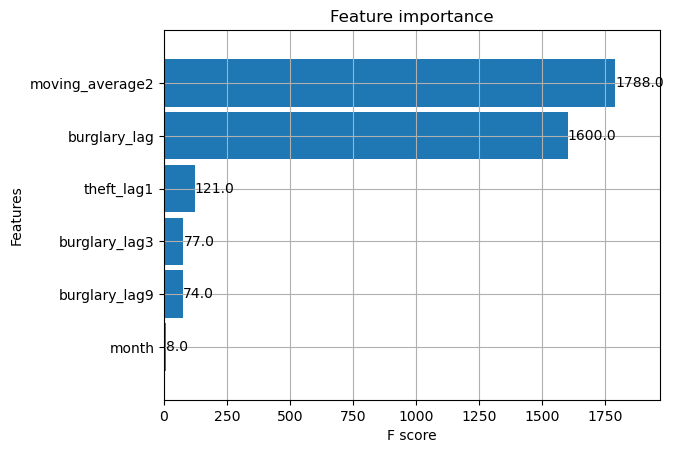

In [61]:
_ = plot_importance(reg, height=0.9)

In [48]:
# Test the model on test data
test_data = hendon_merge[(hendon_merge.index>'2021-12') & (hendon_merge.index<='2022-12')]
test_data = create_features(test_data)

FEATURES = ['burglary_lag','moving_average2','theft_lag1', 'month','burglary_lag3','burglary_lag9']
TARGET = 'burglary counts'
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

# Make predictions on the test data
y_pred = reg.predict(X_test)

# Evaluate the model's performance
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(score)

7.976317499833957


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\3041458704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [64]:
# Rerun the model on the whole dataset and predict the future

# Create features for the complete dataset
complete_dataset = create_features(hendon_merge)

# Select the features for prediction
#prediction_features = ['burglary_lag', 'moving_average2', 'theft counts', 'theft_average3','month']
prediction_features = ['burglary_lag','moving_average2','theft_lag1', 'month','burglary_lag3','burglary_lag9']
target = 'burglary counts'
X_all = complete_dataset[prediction_features]
y_all = complete_dataset[target]

# Use the trained XGBoost model to predict the values for the next few months
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.005)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)
complete_dataset.index

[23:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.58502
[100]	validation_0-rmse:20.41687
[200]	validation_0-rmse:13.00853
[300]	validation_0-rmse:8.39485
[400]	validation_0-rmse:5.51054
[500]	validation_0-rmse:3.68038
[600]	validation_0-rmse:2.51412
[700]	validation_0-rmse:1.75672
[800]	validation_0-rmse:1.25344
[900]	validation_0-rmse:0.92390
[1000]	validation_0-rmse:0.70511
[1100]	validation_0-rmse:0.55704
[1200]	validation_0-rmse:0.46238
[1300]	validation_0-rmse:0.39201
[1400]	validation_0-rmse:0.34047
[1500]	validation_0-rmse:0.29745
[1600]	validation_0-rmse:0.26585
[1700]	validation_0-rmse:0.24490
[1800]	validation_0-rmse:0.22810
[1900]	validation_0-rmse:0.21375
[1999]	validation_0-rmse:0.19412


DatetimeIndex(['2010-12-01', '2011-01-01', '2011-02-01', '2011-03-01',
               '2011-04-01', '2011-05-01', '2011-06-01', '2011-07-01',
               '2011-08-01', '2011-09-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='Month', length=146, freq=None)

In [68]:
start_date = '2023-01-01'
end_date = '2023-03-01'

# Create the DatetimeIndex with the desired range of dates
future = pd.date_range(start=start_date, end=end_date, freq='MS')

future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
complete_dataset['isFuture'] = False
df_and_future = pd.concat([complete_dataset, future_df])
df_and_future = create_features(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()
future_w_features['pred'] = reg.predict(future_w_features[prediction_features])
#future_w_features['pred'].plot(figsize=(10, 5),
                               #color='blue',
                               #ms=1,
                               #lw=1,
                               #title='Future Predictions')
#plt.show()


### Holt\'s Linear Exponential Smoothing Forecast

In [44]:
# Convert the 'date' column to datetime
hendon_merge.index = pd.to_datetime(hendon_merge.index)

# Apply Holt's Linear Exponential Smoothing
model = sm.tsa.ExponentialSmoothing(hendon_merge['burglary counts'], trend='add', seasonal='add', seasonal_periods=12,
                                    damped=True)
results = model.fit()

# Make predictions using the trained model
predictions = results.predict(start=hendon_merge.index[0], end=hendon_merge.index[-1])

# Print the predictions
print(predictions)


2010-12-01    47.828163
2011-01-01    44.713159
2011-02-01    42.491590
2011-03-01    46.638138
2011-04-01    42.511902
                ...    
2022-09-01    21.959703
2022-10-01    24.230943
2022-11-01    26.892285
2022-12-01    27.230771
2023-01-01    22.400762
Freq: MS, Length: 146, dtype: float64


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_5256\919421821.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = sm.tsa.ExponentialSmoothing(hendon_merge['burglary counts'], trend='add', seasonal='add', seasonal_periods=12,
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [46]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(hendon_merge['burglary counts'], predictions))
resids = hendon_merge['burglary counts']- predictions
mae = mean_absolute_error(hendon_merge['burglary counts'], predictions)

# Print the RMSE
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 7.9524082493790695
MAE: 6.226778000377813


In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(resids, lags=10, boxpierce=True)

print(lb_test)

     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.885298   0.346755  0.867352   0.351689
2   1.268464   0.530343  1.240163   0.537900
3   1.337313   0.720292  1.306686   0.727546
4   1.596224   0.809471  1.555101   0.816838
5   1.792466   0.877051  1.742060   0.883559
6   3.014568   0.807016  2.898103   0.821523
7   3.132785   0.872453  3.009132   0.884156
8   3.672090   0.885431  3.511997   0.898257
9   3.980534   0.912689  3.797516   0.924227
10  4.224468   0.936653  4.021671   0.946364


In [31]:
# Convert the 'Month' column to datetime if it's not already in datetime format
hendon_merge.index = pd.to_datetime(hendon_merge.index)

# Apply Holt's Linear Exponential Smoothing
model = sm.tsa.ExponentialSmoothing(hendon_merge['burglary counts'], trend='add', seasonal='add', seasonal_periods=12,
                                    damped=True)
results = model.fit()

# Set the forecasting horizon
forecast_horizon = 12 

# Create the extended index for forecasting
extended_index = pd.date_range(hendon_merge.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')

# Make predictions for the extended index using the trained model
predictions = results.predict(start=len(hendon_merge), end=len(hendon_merge) + forecast_horizon - 1)

# Create the forecast DataFrame with the extended index and predictions
forecast = pd.DataFrame(predictions, index=extended_index, columns=['Forecast'])

# Print the forecast
print(forecast)


             Forecast
2023-02-01  20.762718
2023-03-01  24.742083
2023-04-01  19.887825
2023-05-01  20.200047
2023-06-01  17.678275
2023-07-01  16.573120
2023-08-01  17.217344
2023-09-01  19.944421
2023-10-01  23.588309
2023-11-01  24.731415
2023-12-01  25.055331
2024-01-01  22.043596


C:\Users\xiaoyawang\AppData\Local\Temp\ipykernel_26256\1183490616.py:5: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = sm.tsa.ExponentialSmoothing(hendon_merge['burglary counts'], trend='add', seasonal='add', seasonal_periods=12,
C:\Users\xiaoyawang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


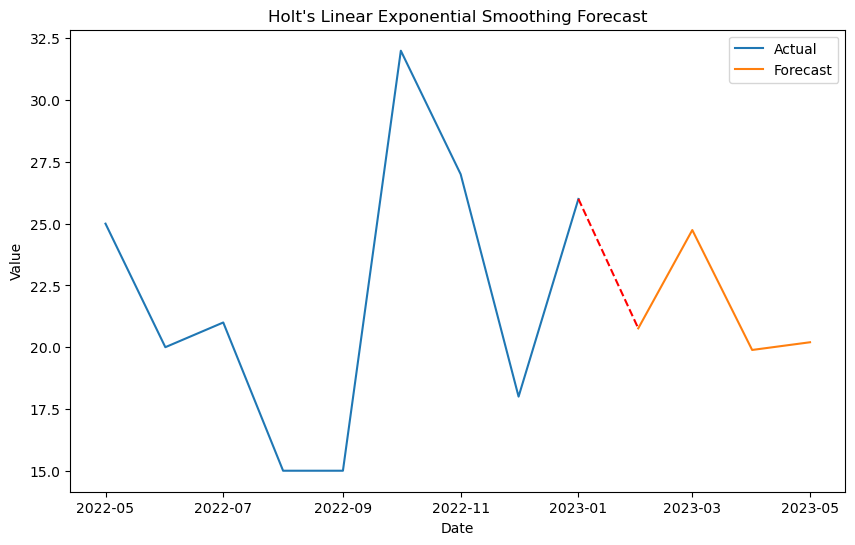

In [45]:
mask_m = (hendon_merge.index >= '2022-05') & (hendon_merge.index <= '2023-05')
mask_f = (forecast.index >= '2022-05') & (forecast.index <= '2023-05')
# Plotting the forecasted values
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Plotting the actual values
plt.plot(hendon_merge[mask_m].index, hendon_merge[mask_m]['burglary counts'], label='Actual')

# Plotting the forecasted values
plt.plot(forecast[mask_f].index, forecast[mask_f]['Forecast'], label='Forecast')

# Connect actual data point with forecasted point
last_actual_date = hendon_merge[mask_m].index[-1]
last_actual_value = hendon_merge[mask_m]['burglary counts'].iloc[-1]
first_forecast_date = forecast[mask_f].index[0]
first_forecast_value = forecast[mask_f]['Forecast'].iloc[0]
plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color='red', linestyle='dashed')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Holt's Linear Exponential Smoothing Forecast")

# Add a legend
plt.legend()

# Show the plot
plt.show()

